In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
# Add the directory containing diffusive_nested_sampling to sys.path
sys.path.append(os.path.abspath( "../.."))
import spike_and_slab

In [3]:
# Likelihood function
def likelihood(x):
    '''
    20-D spike and slab likelihood function

    @param x : coordinate
    @return L : likelihood
    '''
    u = 0.01
    v = 0.1

    # Spike
    t1 = np.sum(-0.5 * (x / v) ** 2) - x.size * np.log(v * np.sqrt(2 * np.pi))
    
    # Slab
    t2 = np.sum(-0.5 * ((x - 0.031) / u) ** 2) - x.size * np.log(u * np.sqrt(2 * np.pi))
    
    return (np.exp(t1) + (100 * np.exp(t2)))

(-0.05, 0.15)

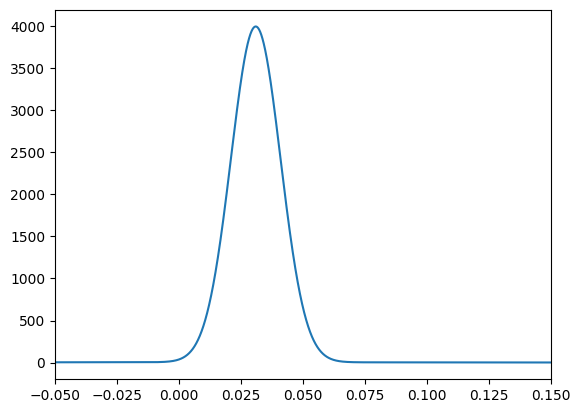

In [4]:
x = np.linspace(-0.05, 0.15, 100000)
y = [likelihood(x_i) for x_i in x]
plt.plot(x, y)
plt.xlim(-0.05, 0.15)

In [5]:
chain, levels = spike_and_slab.main()

100%|██████████| 110/110 [03:26<00:00,  1.88s/it]


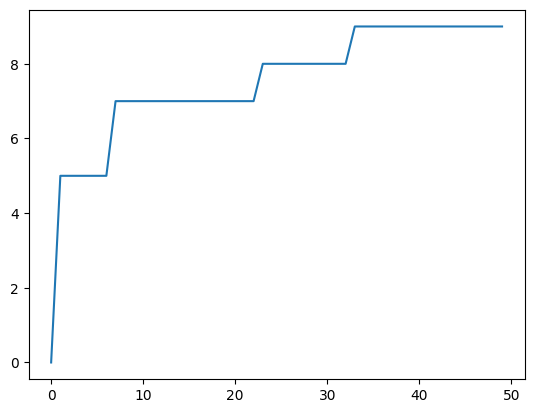

In [ ]:
y = chain['j'][:50000]
x = range(len(y))
plt.plot(x, y)

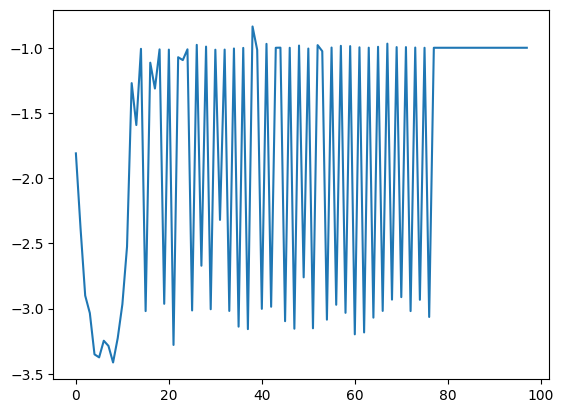

In [7]:
x = range(98)
Xs = np.log([level.get_X for level in levels])
y = Xs[1:] - Xs[:-1]
plt.plot(x, y)

In [8]:
print([level.bound for level in levels])

[0.0, 5.685794801350871e-293, 3.7787400770030025e-273, 4.630542295923966e-252, 8.833017988001542e-233, 1.2339626338767278e-210, 2.282278286877887e-189, 2.91189704173454e-172, 3.964938355301416e-155, 1.4951885920181725e-138, 5.543619902208083e-125, 3.401044111194765e-114, 4.229553241127178e-103, 1.7659615616376964e-102, 2.89196004916815e-100, 5.543619902208083e-125, 5.0493236767600336e-98, 1.7916790716917257e-97, 1.1557323225311292e-96, 5.543619902208083e-125, 9.856582582367778e-95, 5.543619902208083e-125, 8.043149866858467e-94, 1.6327998229133628e-93, 2.6019963681415093e-93, 5.543619902208083e-125, 2.8646459044779335e-92, 3.016758033745889e-117, 4.064152974695324e-90, 5.543619902208083e-125, 3.765809778184731e-89, 1.4887475772667208e-108, 1.3949095034667201e-87, 5.543619902208083e-125, 4.462509591097223e-87, 5.543619902208083e-125, 1.4420965821264434e-86, 5.543619902208083e-125, 6.870956923755036e-86, 1.481053237955556e-85, 5.543619902208083e-125, 4.934806745565499e-85, 8.5877255651650